# XG325: Explainable Artificial Intelligence
    
## Local Intrinsic Dimensionality

**Week 08 | Lecture 04**

_Saturday, April 26, 2025_

Presented by Dr. Marcin Abram


### Introduction

Local Intrinsic Dimensionality (LID) can be seen as the minimal number of variables necessary to represent the dataset.

We demonstrate _Two-NN_, a method of measuring the Local Intrinsic Dimensionality (LID) of a dataset. 

This work follows Elena Facco, Maria d’Errico, Alex Rodriguez and Alessandro Laio, "Estimating the intrinsic dimension of datasets by a minimal neighborhood information". The code below was adopted form https://github.com/fmottes/TWO-NN.


### Scope of the work

 1. We show the implementation of the algorithm.
 2. We test the algorithm on dummy dataset.
 3. We replicate some results from the paper.
 4. We apply the method to measure local intrinsic dimensionality of "Number 1" from the MNIST dataset.

### Library Imports

We will pre-load all libraries that we will use in that notebook.

The notebook was tested with python 3.8, and with the following package versions:

    Package                           Version
    --------------------------------- ----------
    numpy                             1.18.5
    pandas                            1.1.5
    scikit-image                      0.18.0
    scikit-learn                      0.23.2
    scipy                             1.4.1
    tensorflow-gpu                    2.3.0
    tensorflow-hub                    0.10.0

In [1]:
# Standard libraries
import collections
import os
import json
import random
import sys
import time

# Libraries you must install (e.g. using pip install name_of_the_library)
import math
import numpy
import pandas
import scipy
import skimage.measure
import skimage.transform
import sklearn.datasets
import sklearn.model_selection
import sklearn.linear_model
import sklearn.cluster
import tensorflow
import tensorflow_hub

# Error levels, see https://github.com/tensorflow/tensorflow/issues/37876
tensorflow.get_logger().setLevel("ERROR")

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Section 1: Algorithm Implementation

The code below was adopted form https://github.com/fmottes/TWO-NN.

In [2]:
def local_intrinsic_dimensionality(data, cutoff=0.99, plot=False):
    """Calculate intrinsic dimension of a dataset.
    
    Args:
        data (numpy.array): 2-D numpy array ('float32' or 'float64' dtype).
        cutoff (float): cutoff value for the regression
        plot (bool): indicator if plot should be printed

    Returns:
        dim (float): intrinsic dimensionality of the set
    """
    assert data.dtype is numpy.dtype(numpy.float32) or data.dtype is numpy.dtype(numpy.float64)
    assert len(data.shape) == 2
    
    # Calculate mu, the ration between the second and the first distance, r2/r1
    mu = []
    for i, x in enumerate(data):
        distance = numpy.sort(numpy.sqrt(numpy.sum((x-data)**2, axis=1)))
        distance = distance[distance > 0]
        r1, r2 = distance[:2]
        mu.append((i+1, r2/r1))
    
    # Prepare the permutation function
    sigma_i = dict(zip(
        range(1, len(mu) + 1),
        numpy.array(sorted(mu, key=lambda x: x[1]))[:,0].astype(int)))
        
    # Calculate the CDF, F(mu_{sigma(i)})
    N = len(data)
    mu = dict(mu)
    F_i = {sigma_i[i]: i/N for i in mu}

    # Prepare the dependent and independent variable
    x = numpy.log([mu[i] for i in sorted(mu.keys())])
    y = numpy.array([1-F_i[i] for i in sorted(mu.keys())])

    # Avoid having log(0)
    x = x[y>0]
    y = y[y>0]
    y = -1*numpy.log(y)
    
    # Sort
    idx = numpy.argsort(x)[:int(cutoff*N)]
    sorted_x = x[idx].reshape(-1, 1)
    sorted_y = y[idx]
    
    # Fit linear regression
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    model.fit(sorted_x, sorted_y)
    
    if plot:
        plt.plot(x, y, 'ko')
        plt.plot(sorted_x, model.predict(sorted_x), 'r-', linewidth=5)
        plt.grid()
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()
    
    return model.coef_[0]

## Section 2: LID of a Mock Dataset

We calculate LID of a random, uniform hyper-cube.

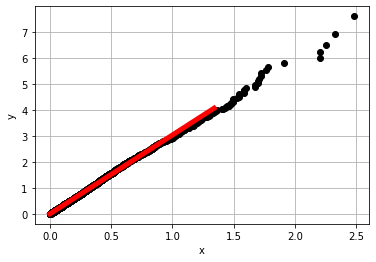

3.033539803892212

In [3]:
# Calculate intrinsic dimension of a hyper-cube
data = numpy.random.uniform(0, 1, size=(2_000, 3))
local_intrinsic_dimensionality(data, cutoff=0.98, plot=True)

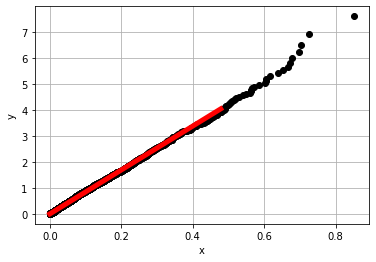

8.441785407869661

In [4]:
# Calculate intrinsic dimension of a hyper-cube
data = numpy.random.uniform(0, 1, size=(2_000, 10))
local_intrinsic_dimensionality(data, cutoff=0.98, plot=True)

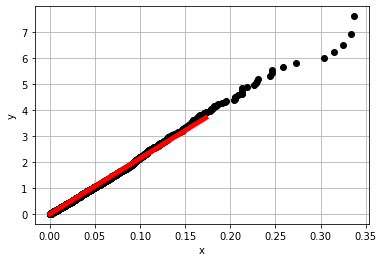

21.410538365879134

In [5]:
# Calculate intrinsic dimension of a hyper-cube
data = numpy.random.uniform(0, 1, size=(2_000, 30))
local_intrinsic_dimensionality(data, cutoff=0.98, plot=True)

**Interpretation:** The method works well in low-dimensions. In high-dimension, the method underestimate the local intrinsic dimension of the dataset. It can be related, to the sharp boundaries between the occupied region and the empty region. The fact that the dimension is underestimated also makes sense: in high dimensions most weight is located on the shell of the hypercube (so the detected dimensionality should we lower then the actual dimensionality).

## Section 3: LID of a Swiss Roll

We calculate LID of a 3-D Swiss Roll

In [6]:
data, color = sklearn.datasets.make_swiss_roll(n_samples=2000, noise=0.0)
data.shape

(2000, 3)

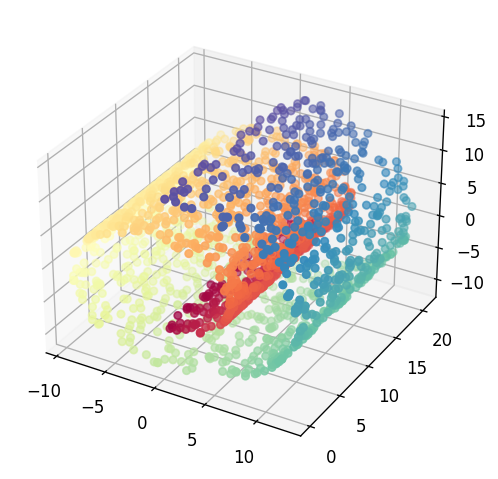

In [7]:
fig = plt.figure(dpi=120, figsize=(5, 5))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, cmap=plt.cm.Spectral)
plt.show()

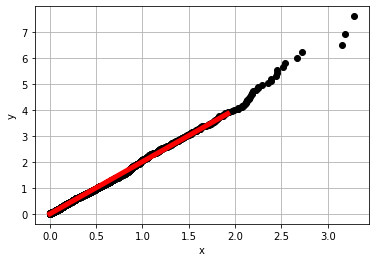

2.007913658523794

In [8]:
local_intrinsic_dimensionality(data, cutoff=0.98, plot=True)

**Interpretation:** The calculated intrinsic dimensionality match the expected value (two).

## Section 4: LID of MNIST Numbers

We calculate LID of MNIST numbers 1 and 2.

In [9]:
(trainval_x, trainval_y), (test_x, test_y) = tensorflow.keras.datasets.mnist.load_data()
trainval_x.shape, trainval_y.shape, trainval_x.dtype

((60000, 28, 28), (60000,), dtype('uint8'))

In [10]:
# We can not perform the calculations with unit8 (not enough precision)
trainval_x = trainval_x.astype('float64')
trainval_x.shape, trainval_x.dtype

((60000, 28, 28), dtype('float64'))

### MNIST Number 2 (Replication Study)

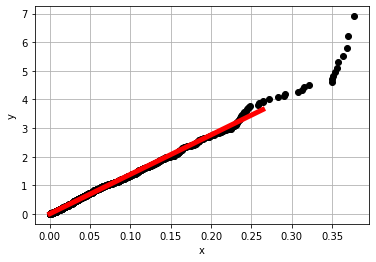

13.809498905921416

In [11]:
# To make it faster, we calculate the LID using only a fraction of numbers
data = trainval_x[trainval_y == 2].reshape(-1, 28*28)
local_intrinsic_dimensionality(data[:1000], cutoff=0.98, plot=True)

### MNIST Number 1

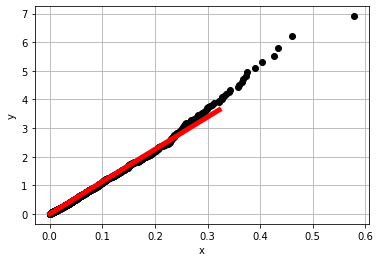

11.292288329348368

In [12]:
# To make it faster, we calculate the LID using only a fraction of numbers
data = trainval_x[trainval_y == 1].reshape(-1, 28*28)
local_intrinsic_dimensionality(data[:1000], cutoff=0.98, plot=True)

**Interpretation:** We get a good agreement with the numbers reported in the paper. We got that LID of number 1 is lower than LID of number 2, which makes sense.

## Summary

We have presented a method of calculating Local Intrinsic Dimensionality (LID) using the Two-NN method. We noticed, that in high-dimensions, on synthetic benchmarks, that method might underestimate the true LID. However, in practice, it works reasonably well (the LID of MNIST numbers was estimated correctly).